In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn')

We first run the script example_pred_variation.py to generate the prediction results. The scripts looks specifically at variations between training runs and the effect of spinning up on the predictions

In [67]:
#load data from output of example_pred_variation.py
lyap = 0.9056
var = np.load('results/pred_variation.npz', allow_pickle = True)
x = [np.vstack(x) for x in var['x']]
var = var['pred'].astype(np.float64)/lyap

# Effect of Training

We analyze the distribution of predictions for different reservoirs all with the same parameters.  This shows the effect of random variations in the connectivity matrix as well as in Win, training data...etc. 10 reservoirs were trained and then predictions were generated for 4000 different randomly generated time series per reservoir.

The mean prediction time is 7.33 with std 2.20


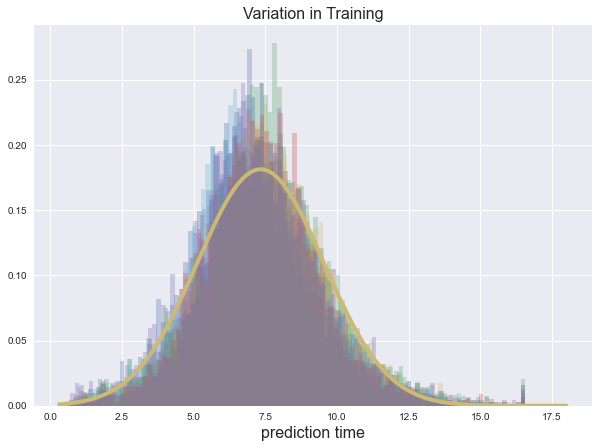

In [92]:
fig = plt.figure(figsize = (10, 7))
for i in range(len(var)):
    plt.hist(var[i], density = True, bins = 100, alpha = 0.3);

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
# var_train = np.mean(var, axis = 0)
# xt = plt.xticks()[0]  
xmin, xmax = np.min(var), np.max(xt)  
lnspc = np.linspace(xmin, xmax, len(var_train))

# get mean and standard deviation  
m = np.mean(np.mean(var, axis = 1)) 
s = np.mean(np.std(var, axis = 1))
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm", lw = 4) # plot it
plt.xlabel('prediction time', fontsize = 16)
plt.title('Variation in Training', fontsize = 16);
print('The mean prediction time is {:1.2f} with std {:1.2f}'.format(m, s))

To me this shows that there is a slight variation between the trained reservoirs but not that much O(1 lyapunov time).  Therefore the random selection of connections and Win as well as the training data does not effect the predictability of the reservoir that much.

# Predictability on Location in the Attractor

Given that there is an range of values given for each trained reservoir we can take a look at which points tend to have better predictions across all the attractors.

Plotted here is the position on the attractor at which the prediction starts and the color indicates the predictability.

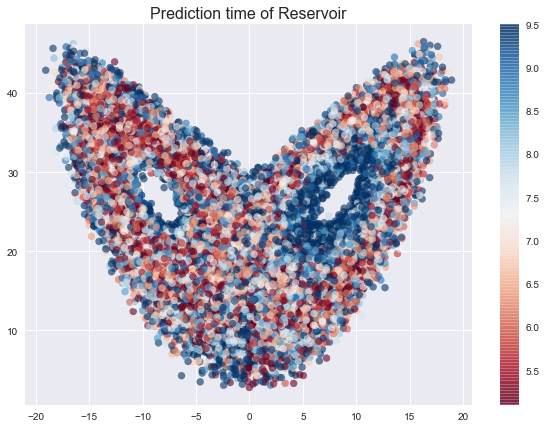

In [140]:
fig = plt.figure(figsize = (10, 7))
for i in range(len(var)):
    plt.scatter(x[i][:, 0], x[i][:, 2], c = var[i], cmap = 'RdBu',
               alpha = 0.6, vmin = 5.1, vmax = 9.5)
plt.colorbar()
plt.title('Prediction time of Reservoir', fontsize = 16);

What this indicates is that the centers of the lobes and the outside give good predictions while the center middle part of the attractor tends to give worse predictions.

The thought that these areas might correspond to the finite time lyapunov exponents (FTLE)

# Correlation of Prediction with FTLE

To see if the prediction time is correlated with the FTLE we calculate the FTLE for the starting prediction point and then do a linear regression over the prediction time

In [223]:
import sys
sys.path.insert(1, '../')
from system import *

sigma = 10   # Prandlt number
rho = 28     # Rayleigh number
beta = 8.0/3

D = 3

#lorenz63 model
def lorenz(n, t, p):
    sigma, rho, beta = p
    x, y, z = n
    dxdt = sigma*(y-x)
    dydt = x*(rho-z)-y
    dzdt = x*y - beta*z
    dXdt = [dxdt, dydt, dzdt]
    return dXdt

def jac(X, t, p):
    sigma, rho, beta = p
    x, y, z = X
    return np.array([[-sigma, sigma, 0],
                     [-z+rho, -1, -x],
                     [y, x, -beta]])

# build the system from the dynamical equations
lor63sys = system(lorenz, (sigma, rho, beta), D, 0.001, fjac = jac)

L = 32
dt = 0.05
T = L*dt
skip = 5
LE = lor63sys.localExp(x[0][::skip], L, dt, multi = True)

In [224]:
print('Calculated FTLE with T = {:1.2f}'.format(T))

Calculated FTLE with T = 1.60


In [225]:
import scipy
LLE = LE[:, 0]
v = var[0][::skip]
result = scipy.stats.linregress(LLE, v)

This is a plot of the FTLE vs Prediction time.  The linear regression shows there is a negative correlation between the FTLE and prediction time. Thus as the FTLE increases the prediction time decreases as one would expect

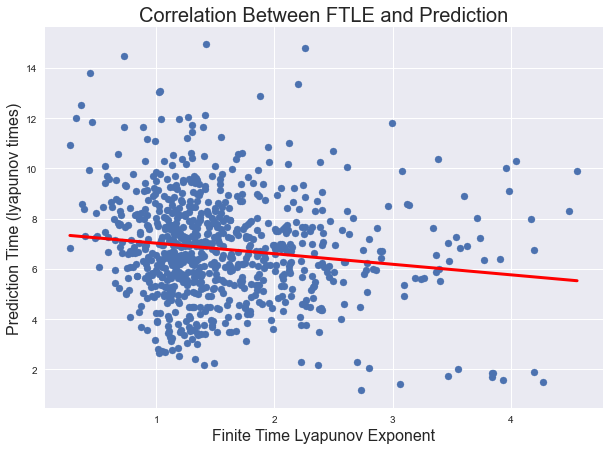

In [233]:
fig = plt.figure(figsize = (10, 7))
x_lle = np.arange(np.min(LLE), np.max(LLE), 0.01)
plt.plot(x_lle, result.slope*x_lle+result.intercept, lw = 3, c = 'r')
plt.scatter(LLE, v)
plt.xlabel('Finite Time Lyapunov Exponent', fontsize = 16)
plt.ylabel('Prediction Time (lyapunov times)', fontsize = 16)
plt.title('Correlation Between FTLE and Prediction', fontsize = 20);

In [229]:
result.pvalue

6.245311699961832e-05

We see that the pvalue is significantly lower than 0.01 thus we can reject the null hypothesis and say with certainty that the FTLE is correlated with prediction time.